# Second fine-tuning with a 0.5B parameter model

My goal is to fine-tune meta-llama/Meta-Llama-3-8B on timdettmers/openassistant-guanaco.  I've already fine-tuned a 0.5B model with that dataset, but I found that the model very easily overfit.  Random thought: maybe the format of the data, being very much like markdown, is too easy to learn?  Let's see what happens if we change the format to match the old Llama-2 instruction format.  According to 
[this reddit post](https://www.reddit.com/r/LocalLLaMA/comments/155po2p/get_llama_2_prompt_format_right/) it's this:

```
<s>[INST] <<SYS>>
{{ system_prompt }}
<</SYS>>

{{ user_message }} [/INST]
```

They also give the default system prompt, so the whole thing would look like this:

```
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>

There's a llama in my garden 😱 What should I do? [/INST]
```

Let's pre-process the dataset to get that :-)

## The dataset


In [1]:
dataset_source = "timdettmers/openassistant-guanaco"

In [2]:
from datasets import load_dataset

dataset = load_dataset(dataset_source)

Repo card metadata block was not found. Setting CardData to empty.


In [3]:
dataset["train"]

Dataset({
    features: ['text'],
    num_rows: 9846
})

In [4]:
dataset["train"][:10]

{'text': ['### Human: Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.### Assistant: "Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, and reduced bargaining p

In [5]:
print(dataset["train"][1]["text"])

### Human: ¿CUales son las etapas del desarrollo y en qué consisten según Piaget?### Assistant: Jean Piaget fue un psicólogo suizo que propuso una teoría sobre el desarrollo cognitivo humano que consta de cuatro etapas:

Etapa sensoriomotora (0-2 años): Durante esta etapa, el niño aprende a través de sus sentidos y movimientos. Descubre que sus acciones pueden tener un impacto en el entorno y comienza a formarse una idea básica de objetividad y continuidad.

Etapa preoperatoria (2-7 años): En esta etapa, el niño comienza a desarrollar un pensamiento simbólico y a comprender que las cosas pueden representar a otras cosas. También comienzan a desarrollar un pensamiento lógico y a comprender conceptos como la causa y el efecto.

Etapa de operaciones concretas (7-12 años): Durante esta etapa, el niño desarrolla un pensamiento lógico y comprende las relaciones causales. Empiezan a comprender que las cosas pueden tener múltiples perspectivas y que los conceptos pueden ser más complejos de lo

Right, so we should just be able to map a regex and a bit of search and replace over that.  Let's give it a whirl.  With a spot of help from ChatGPT for the regex:

In [6]:
import re

prompt_template = """
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>

{question} [/INST]
{response}
"""

pattern = r"### Human: (.*?)### Assistant: (.*)"

def rewrite_prompts(examples):
    questions = []
    responses = []
    # Iterate over each example
    for text in examples["text"]:
        match = re.search(pattern, text, re.DOTALL)
        if match:
            question = match.group(1).strip()
            response = match.group(2).strip()
            reformatted_text = prompt_template.format(question=question, response=response)
            while "### Human: " in reformatted_text:
                reformatted_text = reformatted_text.replace("### Human: ", "[INST]", 1)
                if "### Assistant: " in reformatted_text:
                    reformatted_text = reformatted_text.replace("### Assistant: ", "[/INST]\n", 1)
                else:
                    reformatted_text += "[/INST]\n"
                    
            responses.append(reformatted_text)
        else:
            # You might want to handle errors differently
            responses.append("Error: Did not match expected pattern.")
    return {"reformatted_text": responses}

# Apply the function to your dataset
reformatted_dataset = dataset.map(rewrite_prompts, batched=True)

In [7]:
print(reformatted_dataset["train"][1]["text"])

### Human: ¿CUales son las etapas del desarrollo y en qué consisten según Piaget?### Assistant: Jean Piaget fue un psicólogo suizo que propuso una teoría sobre el desarrollo cognitivo humano que consta de cuatro etapas:

Etapa sensoriomotora (0-2 años): Durante esta etapa, el niño aprende a través de sus sentidos y movimientos. Descubre que sus acciones pueden tener un impacto en el entorno y comienza a formarse una idea básica de objetividad y continuidad.

Etapa preoperatoria (2-7 años): En esta etapa, el niño comienza a desarrollar un pensamiento simbólico y a comprender que las cosas pueden representar a otras cosas. También comienzan a desarrollar un pensamiento lógico y a comprender conceptos como la causa y el efecto.

Etapa de operaciones concretas (7-12 años): Durante esta etapa, el niño desarrolla un pensamiento lógico y comprende las relaciones causales. Empiezan a comprender que las cosas pueden tener múltiples perspectivas y que los conceptos pueden ser más complejos de lo

In [8]:
print(reformatted_dataset["train"][1]["reformatted_text"])


<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>

¿CUales son las etapas del desarrollo y en qué consisten según Piaget? [/INST]
Jean Piaget fue un psicólogo suizo que propuso una teoría sobre el desarrollo cognitivo humano que consta de cuatro etapas:

Etapa sensoriomotora (0-2 años): Durante esta etapa, el niño aprende a través de sus sentidos y movimientos. Descubre que sus acciones pueden tener un impacto en el entorno y comienza a formarse una idea básica de objetividad y continuidad.

Etapa preoperato

Looks good!  Let's look for any errors

In [9]:
for row in list(reformatted_dataset["train"]) + list(reformatted_dataset["test"]):
    if row["reformatted_text"] == "Error: Did not match expected pattern.":
        print(row["text"])


Awesome!

Sanity check that there are no remaining prompts

In [10]:
human_prompts = []
assistant_prompts = []
for row in list(reformatted_dataset["train"]) + list(reformatted_dataset["test"]):
    if "### Human: " in row["reformatted_text"]:
        human_prompts.append(row["reformatted_text"])
    if "### Assistant: " in row["reformatted_text"]:
        assistant_prompts.append(row["reformatted_text"])
        
assert len(human_prompts) == 0
assert len(assistant_prompts) == 0

## The model

Same base model as last time

In [11]:
base_model = "Qwen/Qwen1.5-0.5B"

In [12]:
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(base_model)
model = AutoModelForCausalLM.from_pretrained(base_model, device_map="cuda")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


So now let's ask it a question, using the format we saw earlier

In [13]:
import time
from transformers import pipeline

def ask_question(model, question):
    pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_new_tokens=2048)
    prompt = prompt_template.format(question=question, response="")
    tokens_in = len(tokenizer(prompt)["input_ids"])
    start = time.time()
    result = pipe(prompt)
    end = time.time()
    generated_text = result[0]['generated_text']
    tokens_out = len(tokenizer(generated_text)["input_ids"])
    print(generated_text)
    tokens_generated = tokens_out - tokens_in
    time_taken = end - start
    tokens_per_second = tokens_generated / time_taken
    print(f"{tokens_generated} tokens in {time_taken:.2f}s: {tokens_per_second:.2f} tokens/s)")
    
ask_question(model, "Who is Leonardo Da Vinci?")


<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>

Who is Leonardo Da Vinci? [/INST]

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST>

<</INST

It didn't have a clue what to do with that!  Which makes a lot of sense.  Let's see if we can train it to understand.  Once again, we'll start by finding out how many tokens we have in our datasets.

In [14]:
tokenized_train_dataset = reformatted_dataset['train'].map(lambda row: tokenizer(row["reformatted_text"]))
tokenized_test_dataset = reformatted_dataset['test'].map(lambda row: tokenizer(row["reformatted_text"]))

9846


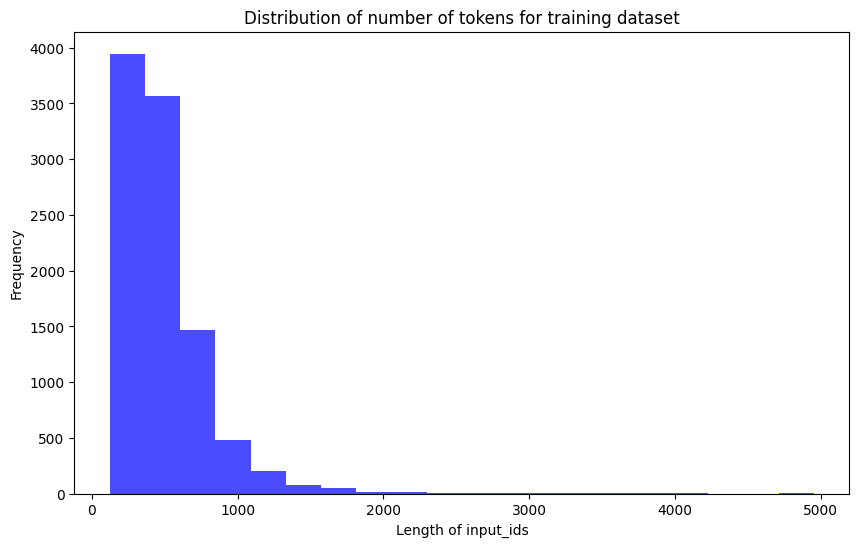

518


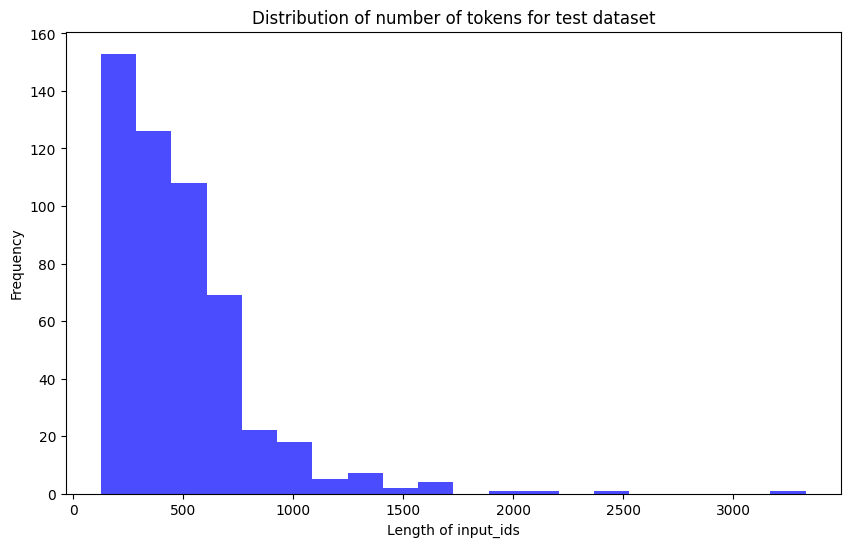

In [15]:
import matplotlib.pyplot as plt

def plot_data_lengths(dataset_name, dataset):
    lengths = [len(x['input_ids']) for x in dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color="blue")
    plt.xlabel("Length of input_ids")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of number of tokens for {dataset_name} dataset")
    plt.show()

plot_data_lengths("training", tokenized_train_dataset)
plot_data_lengths("test", tokenized_test_dataset)

So 2048 looks acceptable again.  Makes sense, the reformatting won't have changed the number of tokens much.

In [16]:
from transformers import TrainingArguments,Trainer

batch_size = 1
args = TrainingArguments(
    'outputs', 
    learning_rate=8e-5, 
    warmup_ratio=0.1, 
    lr_scheduler_type='cosine', 
    fp16=True,
    evaluation_strategy="epoch", 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size * 2,
    num_train_epochs=2, 
    weight_decay=0.01, 
    report_to='none'
)

In [17]:
def tokenize_function(examples):
    tokenized = tokenizer(examples["reformatted_text"], truncation=True, padding="max_length", max_length=2048)
    tokenized["labels"] = tokenized["input_ids"][:]
    return tokenized

tokenized_dataset = reformatted_dataset.map(tokenize_function, batched=True)

In [18]:
trainer = Trainer(
    model, args, 
    train_dataset=tokenized_dataset['train'], 
    eval_dataset=tokenized_dataset['test'],
    tokenizer=tokenizer,
)

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.537900,0.518223
2,0.316900,0.473606


TrainOutput(global_step=19692, training_loss=0.46182566543383835, metrics={'train_runtime': 5779.0493, 'train_samples_per_second': 3.407, 'train_steps_per_second': 3.407, 'total_flos': 7.46264511727534e+16, 'train_loss': 0.46182566543383835, 'epoch': 2.0})

Turns out that it still starts getting worse validation loss after the second epoch -- so the instruction formatting didn't help with that.  But let's see what we get as a result when we try it!


In [20]:
ask_question(trainer.model, "Who is Leonardo Da Vinci?")


<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>

Who is Leonardo Da Vinci? [/INST]

Leonardo da Vinci was an Italian scientist and artist who is best known for his contributions to the fields of mathematics, physics, and astronomy. He is best known for his theory of relativity and his famous equation, "reduction to absurdity", which demonstrates the limits of mathematics and the importance of empirical observation and experimentation.

Da Vinci was a prominent figure in the early 15th century, when he firs